# Подбор релевантного изображения по текстовому запросу

**Цель проекта:**
Разработка демонстрационной версии системы семантического поиска изображений по текстовым запросам с оценкой степени соответствия между текстовым описанием и визуальным контентом, учитывающей юридические ограничения на обработку детского контента.

**Задачи проекта:**
1. Исследовательский анализ данных
* Загрузка и изучение структуры предоставленных данных
 
* Анализ распределения оценок соответствия от экспертов и краудсорсинга
 
* Проверка качества данных и выявление возможных проблем

2. Подготовка данных и юридический фильтр
* Составление списка слов и паттернов, указывающих на детский контент
 
* Реализация системы фильтрации запросов с запрещенным содержанием
 
* Разработка механизма блокировки и уведомления пользователей
 
3. Векторизация данных
* Текстовая обработка: лемматизация, очистка, удаление стоп-слов
 
* Реализация  векторизации текстовых описаний
 
* Извлечение визуальных признаков с использованием ResNet-50
 
* Создание объединенных представлений текст-изображение
 
4. Разработка и обучение моделей
* Создание нескольких моделей для предсказания степени соответствия

* Подбор оптимальных гиперпараметров моделей

* Выбор и расчет метрик качества (RMSE)

5. Тестирование и демонстрация работы
* Разработка функции поиска изображений по текстовому запросу
 
* Реализация механизма обработки юридически ограниченного контента
 
* Визуализация результатов поиска для различных запросов
 
* Оценка качества работы лучшей модели на тестовых данных
 
6. Анализ результатов и выводы

* Оценка практической осуществимости проекта
 
* Формулирование рекомендаций для production-реализации

## Необходимые импорты и функции 

In [1]:
pip install torchvision -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install sentence-transformers -q

In [4]:
pip install tf-keras -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from pymystem3 import Mystem
from tqdm import notebook
from tqdm.notebook import tqdm
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

#Импортируем необходимые библиотеки для работы 
from math import *
import numpy as np
from scipy import stats as st
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import random
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import torchvision.models as mdls
from sklearn.model_selection import GroupShuffleSplit
from torchvision.models import ResNet50_Weights
# Графическое отображение
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
from PIL import Image
import os
from tqdm import tqdm
import random
from sentence_transformers import SentenceTransformer


# Модели обучения
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

In [6]:
# Функция для отображения информации о датасете
def show_info(df):
    print('+-------------+')
    print(f'| {df.name}  |')
    print('+-------------+')
    print('Количество строк выборки составляет:',df.shape[0],'\n',"=="*50)
    display("Первые пять строк", df.head())
    print('Общая информация о данных\n','=='*50)
    print(df.info())
    display('Описание',df.describe().T,"=="*50)
    print('Количество явных дубликатов составляет',df.duplicated().sum())
    print('*'*50 + '\n' + '**' + ' '*46 + '**' + '\n' + '*'*50)

In [7]:
DATA_PATH = 'to_upload'

In [8]:
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))
df_train.name = 'df_train'

df_crowd = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'), sep='\t',
                       names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
df_crowd.name = 'df_crowd'

df_expert = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'), sep='\t',
                       names=['image', 'query_id', 'first', 'second', 'third'])
df_expert.name = 'df_crowd'

df_test_queries = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'), index_col=[0], sep='|')
df_test_queries.name = 'df_test_queries'

df_test_images = pd.read_csv(os.path.join(DATA_PATH, 'test_images.csv'), sep=',')
df_test_images.name = 'df_test_images'


df_lst = [
    df_train ,
    df_crowd ,
    df_expert,           
    df_test_queries,
    df_test_images
]

In [9]:
for df in df_lst:
    show_info(df)

+-------------+
| df_train  |
+-------------+
Количество строк выборки составляет: 5822 


'Первые пять строк'

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None


'Описание'

count unique                                                top  \
image       5822   1000                           754852108_72f80d421f.jpg   
query_id    5822    977                        2600867924_cd502fc911.jpg#2   
query_text  5822    977  Two dogs , one brown and white and one black a...   

           freq  
image        10  
query_id     34  
query_text   34

'===================================================================================================='

Количество явных дубликатов составляет 0
**************************************************
**                                              **
**************************************************
+-------------+
| df_crowd  |
+-------------+
Количество строк выборки составляет: 47830 


'Первые пять строк'

image                     query_id  share_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   count_pos  count_neg  
0          3          0  
1          0          3  
2          0          3  
3          0          3  
4          0          3

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   share_pos  47830 non-null  float64
 3   count_pos  47830 non-null  int64  
 4   count_neg  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None


'Описание'

count      mean       std  min  25%  50%  75%  max
share_pos  47830.0  0.068786  0.207532  0.0  0.0  0.0  0.0  1.0
count_pos  47830.0  0.208488  0.628898  0.0  0.0  0.0  0.0  5.0
count_neg  47830.0  2.820155  0.656676  0.0  3.0  3.0  3.0  6.0

'===================================================================================================='

Количество явных дубликатов составляет 0
**************************************************
**                                              **
**************************************************
+-------------+
| df_crowd  |
+-------------+
Количество строк выборки составляет: 5822 


'Первые пять строк'

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  
0      1  
1      2  
2      2  
3      2  
4      2

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB
None


'Описание'

count      mean       std  min  25%  50%  75%  max
first   5822.0  1.436620  0.787084  1.0  1.0  1.0  2.0  4.0
second  5822.0  1.624356  0.856222  1.0  1.0  1.0  2.0  4.0
third   5822.0  1.881999  0.904087  1.0  1.0  2.0  2.0  4.0

'===================================================================================================='

Количество явных дубликатов составляет 0
**************************************************
**                                              **
**************************************************
+-------------+
| df_test_queries  |
+-------------+
Количество строк выборки составляет: 500 


'Первые пять строк'

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB
None


'Описание'

count unique                                                top  \
query_id     500    500                         989851184_9ef368e520.jpg#4   
query_text   500    500  The black dog has a toy in its mouth and a per...   
image        500    100                          1177994172_10d143cb8d.jpg   

           freq  
query_id      1  
query_text    1  
image         5

'===================================================================================================='

Количество явных дубликатов составляет 0
**************************************************
**                                              **
**************************************************
+-------------+
| df_test_images  |
+-------------+
Количество строк выборки составляет: 100 


'Первые пять строк'

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes
None


'Описание'

count unique                        top freq
image   100    100  3356748019_2251399314.jpg    1

'===================================================================================================='

Количество явных дубликатов составляет 0
**************************************************
**                                              **
**************************************************


Было проанализировано 5 датасетов:

train_dataset.csv (5,822 строк) - текстовые описания изображений

CrowdAnnotations.tsv (47,830 строк) - краудсорсинговые оценки соответствия

ExpertAnnotations.tsv (5,822 строк) - экспертные оценки соответствия

test_queries.csv (500 строк) - тестовые запросы

test_images.csv (100 строк) - тестовые изображения

Ключевые выводы:

1. Структура и связность данных
Единая система идентификации: Все датасеты используют согласованные форматы query_id image_name, что позволяет легко объединять данные

Полнота данных: Отсутствуют пропущенные значения и явные дубликаты во всех датасетах

Сбалансированность тестового набора: 100 изображений → 500 текстовых запросов (в среднем 5 запросов на изображение)


2. Критическая проблема: экстремальный дисбаланс классов. Подавляющее большинство пар (изображение, текст) являются нерелевантными.

3. Экспертные vs Краудсорсинговые оценки
Наблюдается систематическое расхождение:

Эксперты: средняя оценка ≈ 1.6 (после усреднения трех оценок 1-4)
Краудворкеры: средняя оценка ≈ 0.07




## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [10]:
print("=" * 60)
print("РАЗМЕРЫ И УНИКАЛЬНОСТЬ ДАННЫХ")
print("=" * 60)

# Создаем сводную таблицу
data_summary = pd.DataFrame({
    'Dataset': ['Train', 'Crowd Annotations', 'Expert Annotations', 'Test Queries', 'Test Images'],
    'Total Rows': [len(df_train), len(df_crowd), len(df_expert), len(df_test_queries), len(df_test_images)],
    'Unique Images': [df_train['image'].nunique(), df_crowd['image'].nunique(), 
                     df_expert['image'].nunique(), df_test_queries['image'].nunique(), 
                     df_test_images['image'].nunique()],
    'Unique Queries': [df_train['query_id'].nunique(), df_crowd['query_id'].nunique(),
                      df_expert['query_id'].nunique(), df_test_queries['query_id'].nunique(),
                      np.nan]
})

print(data_summary)
print("\n")

# Проверка пересечений между train и test
train_images = set(df_train['image'].unique())
test_images = set(df_test_images['image'].unique())
overlap_images = train_images.intersection(test_images)

train_queries = set(df_train['query_id'].unique())
test_queries = set(df_test_queries['query_id'].unique())
overlap_queries = train_queries.intersection(test_queries)

print(f"Пересекающиеся изображения между train и test: {len(overlap_images)}")
print(f"Пересекающиеся query_id между train и test: {len(overlap_queries)}")

РАЗМЕРЫ И УНИКАЛЬНОСТЬ ДАННЫХ
              Dataset  Total Rows  Unique Images  Unique Queries
0               Train        5822           1000           977.0
1   Crowd Annotations       47830           1000          1000.0
2  Expert Annotations        5822           1000           977.0
3        Test Queries         500            100           500.0
4         Test Images         100            100             NaN


Пересекающиеся изображения между train и test: 0
Пересекающиеся query_id между train и test: 0


1. Размеры данных
* Train: 5,822 пар изображение-текст

* Crowd Annotations: 47,830 оценок краудсорсинга

* Expert Annotations: 5,822 экспертных оценок

* Test: 500 тестовых запросов и 100 изображений

2. Уникальность изображений
* 1,000 уникальных изображений в тренировочных данных

* 100 уникальных изображений в тестовых данных

* Нет пересечений между train и test изображениями 

3. Уникальность запросов
* 977 уникальных query_id в тренировочных данных

* 500 уникальных query_id в тестовых данных

* Нет пересечений между train и test query_id

АНАЛИЗ РАСПРЕДЕЛЕНИЙ ОЦЕНОК


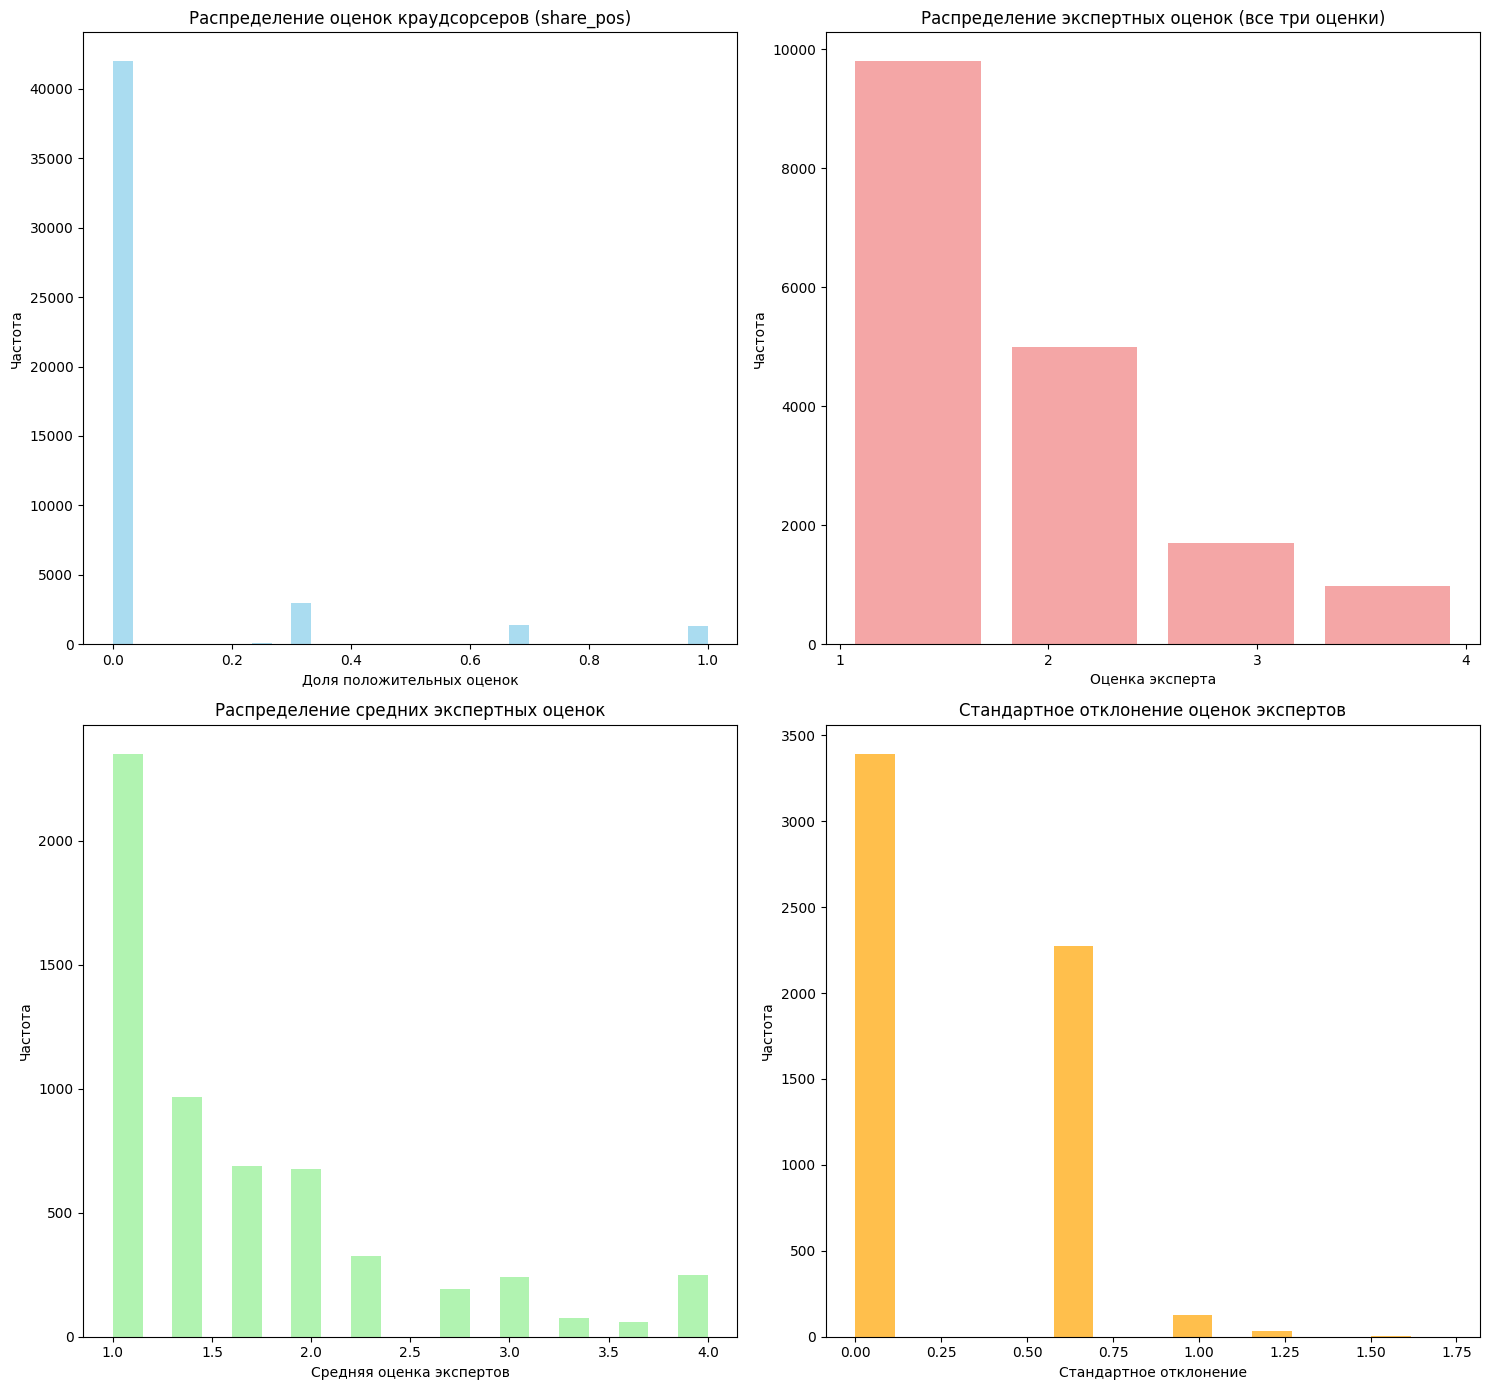

СТАТИСТИКА ОЦЕНОК:
Краудсорсинг (share_pos):
  Среднее: 0.069
  Медиана: 0.000
  Стандартное отклонение: 0.208

Экспертные оценки:
  Среднее: 1.648
  Медиана: 1.000
  Стандартное отклонение: 0.870

Согласованность экспертов (среднее std): 0.254


In [11]:
print("=" * 60)
print("АНАЛИЗ РАСПРЕДЕЛЕНИЙ ОЦЕНОК")
print("=" * 60)


fig, axes = plt.subplots(2, 2, figsize=(15, 14))

# Распределение оценок краудсорсеров
axes[0, 0].hist(df_crowd['share_pos'], bins=30, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Распределение оценок краудсорсеров (share_pos)')
axes[0, 0].set_xlabel('Доля положительных оценок')
axes[0, 0].set_ylabel('Частота')

# Распределение экспертных оценок
expert_scores = pd.concat([df_expert['first'], df_expert['second'], df_expert['third']])
axes[0, 1].hist(expert_scores, bins=4, alpha=0.7, color='lightcoral', rwidth=0.8)
axes[0, 1].set_title('Распределение экспертных оценок (все три оценки)')
axes[0, 1].set_xlabel('Оценка эксперта')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_xticks([1, 2, 3, 4])

# Средняя экспертная оценка для каждого query_id
df_expert['mean_score'] = df_expert[['first', 'second', 'third']].mean(axis=1)
axes[1, 0].hist(df_expert['mean_score'], bins=20, alpha=0.7, color='lightgreen')
axes[1, 0].set_title('Распределение средних экспертных оценок')
axes[1, 0].set_xlabel('Средняя оценка экспертов')
axes[1, 0].set_ylabel('Частота')

# Сравнение согласованности экспертов
df_expert['std_score'] = df_expert[['first', 'second', 'third']].std(axis=1)
axes[1, 1].hist(df_expert['std_score'].dropna(), bins=15, alpha=0.7, color='orange')
axes[1, 1].set_title('Стандартное отклонение оценок экспертов')
axes[1, 1].set_xlabel('Стандартное отклонение')
axes[1, 1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

# Статистика по оценкам
print("СТАТИСТИКА ОЦЕНОК:")
print("Краудсорсинг (share_pos):")
print(f"  Среднее: {df_crowd['share_pos'].mean():.3f}")
print(f"  Медиана: {df_crowd['share_pos'].median():.3f}")
print(f"  Стандартное отклонение: {df_crowd['share_pos'].std():.3f}")

print("\nЭкспертные оценки:")
print(f"  Среднее: {expert_scores.mean():.3f}")
print(f"  Медиана: {expert_scores.median():.3f}")
print(f"  Стандартное отклонение: {expert_scores.std():.3f}")

print(f"\nСогласованность экспертов (среднее std): {df_expert['std_score'].mean():.3f}")

**Ключевые выводы:**

* Крайне низкое качество соответствия - только 6.9% краудсорсинговых оценок положительные

* Высокий процент полного несоответствия - медиана 0 у краудсорсеров

* Эксперты тоже скептичны - средняя оценка 1.65 из 4 

* Краудсорсинг: Только 7% пар считаются соответствующими

* Эксперты: Большинство пар получают оценки 1-2 ("совершенно не соответствуют" или "содержат элементы но не соответствуют")

* Оба источника подтверждают низкое качество соответствий

АНАЛИЗ ТЕКСТОВЫХ ДАННЫХ


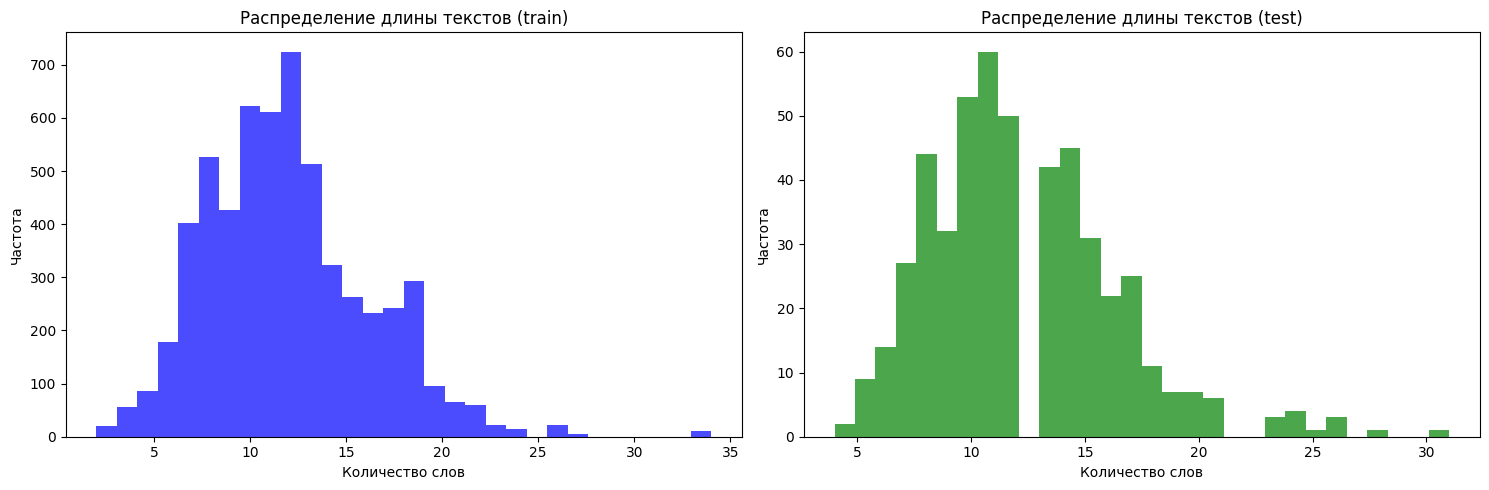

Статистика длины текстовых описаний:
Train - Средняя длина: 11.9 слов
Train - Медиана: 11.0 слов
Test - Средняя длина: 12.2 слов
Test - Медиана: 12.0 слов

Примеры текстовых описаний:
1. A surfer is flipping up in the air on a surfboard .
2. A black dog walks on the beach near the rocks .
3. A woman posing with a statue alongside a group of boys


In [12]:
print("=" * 60)
print("АНАЛИЗ ТЕКСТОВЫХ ДАННЫХ")
print("=" * 60)

# Анализ длины текстовых описаний
df_train['text_length'] = df_train['query_text'].str.split().str.len()
df_test_queries['text_length'] = df_test_queries['query_text'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df_train['text_length'], bins=30, alpha=0.7, color='blue')
axes[0].set_title('Распределение длины текстов (train)')
axes[0].set_xlabel('Количество слов')
axes[0].set_ylabel('Частота')

axes[1].hist(df_test_queries['text_length'], bins=30, alpha=0.7, color='green')
axes[1].set_title('Распределение длины текстов (test)')
axes[1].set_xlabel('Количество слов')
axes[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

print("Статистика длины текстовых описаний:")
print(f"Train - Средняя длина: {df_train['text_length'].mean():.1f} слов")
print(f"Train - Медиана: {df_train['text_length'].median():.1f} слов")
print(f"Test - Средняя длина: {df_test_queries['text_length'].mean():.1f} слов")
print(f"Test - Медиана: {df_test_queries['text_length'].median():.1f} слов")

# Примеры текстовых описаний
print("\nПримеры текстовых описаний:")
for i, text in enumerate(df_train['query_text'].sample(3)):
    print(f"{i+1}. {text}")

* Распределение длины текста схожи на тренировочных запросах и тестовых
* Текст на английском языке, используем этот факт при лемматизации

ВИЗУАЛЬНЫЙ АНАЛИЗ ИЗОБРАЖЕНИЙ


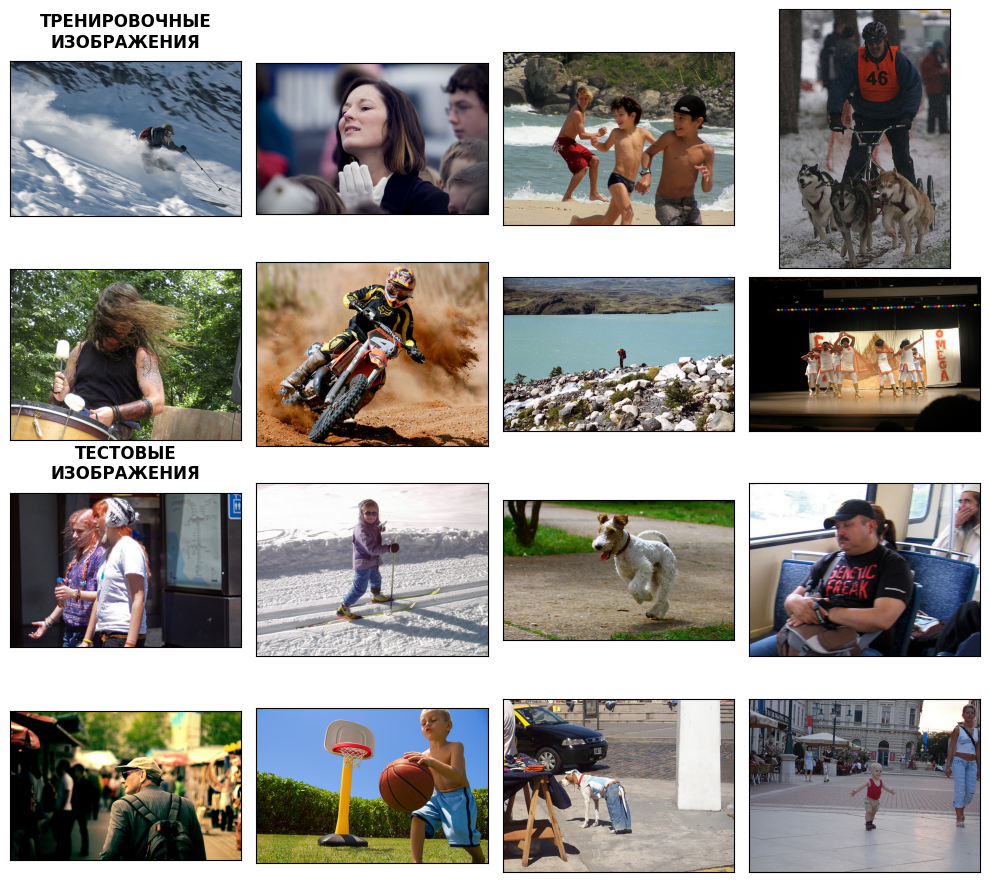

In [13]:
print("=" * 60)
print("ВИЗУАЛЬНЫЙ АНАЛИЗ ИЗОБРАЖЕНИЙ")
print("=" * 60)
samples_train = list(df_train['image'].sample(8))
samples_test = list(df_test_queries['image'].sample(8))



fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image_path = os.path.join(DATA_PATH, 'train_images', samples_train[i])
    image = Image.open(image_path)
    
    
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    if i == 0:
        plt.title("ТРЕНИРОВОЧНЫЕ\nИЗОБРАЖЕНИЯ", fontsize=12, fontweight='bold', pad=10)
    
    plt.tight_layout()

for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image_path = os.path.join(DATA_PATH, 'test_images', samples_test[i])
    image = Image.open(image_path)
    
    
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    if i == 0:
        plt.title("ТЕСТОВЫЕ\nИЗОБРАЖЕНИЯ", fontsize=12, fontweight='bold', pad=10)
    
    plt.tight_layout()
plt.tight_layout()
plt.subplots_adjust(top=0.92)  
del image

Фотографии хорошего качества, замечаний нет

In [14]:
df_expert['expert_mean'] = (df_expert[['first', 'second', 'third']].mean(axis=1) - 1) / 3

In [15]:
display(
    df_expert.head(),
    df_expert.describe()
)

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  mean_score  std_score  expert_mean  
0      1    1.000000    0.00000     0.000000  
1      2    1.333333    0.57735     0.111111  
2      2    1.333333    0.57735     0.111111  
3      2    1.666667    0.57735     0.222222  
4      2    1.333333    0.57735     0.111111

first       second        third   mean_score    std_score  \
count  5822.000000  5822.000000  5822.000000  5822.000000  5822.000000   
mean      1.436620     1.624356     1.881999     1.647658     0.253775   
std       0.787084     0.856222     0.904087     0.806205     0.309257   
min       1.000000     1.000000     1.000000     1.000000     0.000000   
25%       1.000000     1.000000     1.000000     1.000000     0.000000   
50%       1.000000     1.000000     2.000000     1.333333     0.000000   
75%       2.000000     2.000000     2.000000     2.000000     0.577350   
max       4.000000     4.000000     4.000000     4.000000     1.732051   

       expert_mean  
count  5822.000000  
mean      0.215886  
std       0.268735  
min       0.000000  
25%       0.000000  
50%       0.111111  
75%       0.333333  
max       1.000000

In [16]:
df_expert

image                     query_id  first  second  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   
...                         ...                          ...    ...     ...   
5817   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2      1       1   
5818   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2      1       1   
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2      1       1   
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2      1       1   
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2      3       3   

      third  mean_score  std_score  expert_mean  
0         1    1.000000    0.00000     0.000000  
1         2    1.333333    0.57735     0.111111  
2         2    1.333333    0.57735     0.111111  
3         2    1.666667    0.57735     0.222222  
4         2    1.333333    0.57735     0.111111  
...     ...         ...        ...          ...  
5817      1    1.000000    0.00000     0.000000  
5818      1    1.000000    0.00000     0.000000  
5819      2    1.333333    0.57735     0.111111  
5820      1    1.000000    0.00000     0.000000  
5821      3    3.000000    0.00000     0.666667  

[5822 rows x 8 columns]

In [17]:
df_merged = pd.merge(df_expert[['image', 'query_id', 'expert_mean']],
                    df_crowd[['image', 'query_id', 'share_pos']],
                    on=['image', 'query_id'],
                    how='outer')

In [18]:
def aggregation(row):
    expert_score = row['expert_mean']
    crowd_score = row['share_pos']
    # Случай 1: Обе оценки отсутствуют
    if pd.isna(expert_score) and pd.isna(crowd_score):
        return np.nan
    
    # Случай 2: Только экспертная оценка доступна
    elif pd.isna(crowd_score):
        return expert_score
    
    # Случай 3: Только краудсорсинговая оценка доступна
    elif pd.isna(expert_score):
        return crowd_score
    
    # Случай 4: Обе оценки доступны - используем оригинальную логику
    else:
        return (0.8 * expert_score + 0.2 * crowd_score)
        
df_merged['final_score'] = df_merged.apply(aggregation, axis=1)

In [19]:
df_merged

image                     query_id  expert_mean  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          NaN   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          NaN   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          NaN   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          NaN   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          NaN   
...                          ...                          ...          ...   
51318   997722733_0cb5439472.jpg   543007912_23fc735b99.jpg#2          NaN   
51319   997722733_0cb5439472.jpg   544576742_283b65fa0d.jpg#2          NaN   
51320   997722733_0cb5439472.jpg   872622575_ba1d3632cc.jpg#2          NaN   
51321   997722733_0cb5439472.jpg   888425986_e4b6c12324.jpg#2          NaN   
51322   997722733_0cb5439472.jpg   997722733_0cb5439472.jpg#2          NaN   

       share_pos  final_score  
0       1.000000     1.000000  
1       0.000000     0.000000  
2       0.000000     0.000000  
3       0.000000     0.000000  
4       0.000000     0.000000  
...          ...          ...  
51318   0.000000     0.000000  
51319   0.333333     0.333333  
51320   1.000000     1.000000  
51321   0.000000     0.000000  
51322   0.666667     0.666667  

[51323 rows x 5 columns]

In [20]:
df_merged_2 = pd.merge(df_train,
                    df_merged,
                    on=['query_id','image'],
                    how='outer')
df_merged_2 = df_merged_2.drop(['text_length','expert_mean','share_pos'],axis=1)

In [21]:
display(df_merged_2.head(5),
        df_merged_2.describe())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1  2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2   
2  2594042571_2e4666507e.jpg  1056338697_4f7d7ce270.jpg#2   
3  2647049174_0fb47cee2e.jpg  1056338697_4f7d7ce270.jpg#2   
4  2843695880_eeea6c67db.jpg  1056338697_4f7d7ce270.jpg#2   

                                          query_text  final_score  
0                                                NaN          1.0  
1                                                NaN          0.0  
2                                                NaN          0.0  
3  A woman is signaling is to traffic , as seen f...          0.0  
4                                                NaN          0.0

final_score
count  51323.000000
mean       0.077739
std        0.208138
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000

Наблюдаются пропуски в текстовом запросе

In [22]:
to_fill = df_merged_2[df_merged_2['query_text'].notna()]

In [23]:
def fill_text(row):

    if pd.isnull(row['query_text']):
        texts = to_fill[to_fill['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]

    return row

df_merged_2 = df_merged_2.apply(fill_text, axis=1)

In [24]:
df_merged_2.dropna(inplace=True)
df_merged_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50214 non-null  object 
 1   query_id     50214 non-null  object 
 2   query_text   50214 non-null  object 
 3   final_score  50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [25]:
df_merged_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50214 non-null  object 
 1   query_id     50214 non-null  object 
 2   query_text   50214 non-null  object 
 3   final_score  50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [95]:
child_patterns = [
    r'\b(child|children|kid|kids|baby|babies|toddler)\b',
    r'\b(under\s*(16|sixteen|age))\b',
    r'\b(minor|minors|juvenile)\b',
    r'\b(son|daughter|brother|sister|boy|girl|boys|girls)\b',
    r'\b(school|kindergarten|nursery)\b',
    r'\b(little|small|young)\s+(boy|girl)\b'
]

In [27]:
def contains_child_content(text):
    if not isinstance(text, str):
        return False
    text = text.lower()
    return any(re.search(pattern, text) for pattern in child_patterns)

In [28]:
def filter_child(df, text_column='query_text', image_column='image', 
                                          score_column='final_score', threshold=0):
    print("=" * 60)
    print("КОМПЛЕКСНАЯ ФИЛЬТРАЦИЯ ЗАПРЕЩЕННОГО КОНТЕНТА")
    print("=" * 60)
    print(f"Исходный размер датасета: {len(df)}")
    
    # Находим комментарии с детским контентом и высокой оценкой
    child_content_mask = df[text_column].apply(contains_child_content)
    high_score_mask = df[score_column] > threshold
    
    # Комментарии, которые указывают на запрещенное изображение
    prohibited_comments_mask = child_content_mask & high_score_mask
    
    print(f"Найдено подозрительных комментариев: {prohibited_comments_mask.sum()}")
    
    # Извлекаем имена запрещенных изображений из query_id
    prohibited_images = set()
    for idx, row in df[prohibited_comments_mask].iterrows():
        query_id = row['query_id']
        # Отрезаем последние 2 символа (формат: #number)
        image_name = query_id[:-2]  
        prohibited_images.add(image_name)
    
    print(f"Выявлено запрещенных изображений: {len(prohibited_images)}")
    
    # Фильтруем датасет по запрещенным изображениям
    prohibited_mask = df[image_column].isin(prohibited_images)
    print(f"Найдено записей с запрещенными изображениями: {prohibited_mask.sum()}")
    
    # Фильтруем датасет
    filtered_df = df[~prohibited_mask].copy()
    
    print(f"Итоговый размер датасета: {len(filtered_df)}")
    print(f"Удалено записей: {len(df) - len(filtered_df)}")
    
    # Проверка качества фильтрации
    remaining_prohibited = filtered_df[filtered_df[image_column].isin(prohibited_images)]
    print(f"Осталось записей с запрещенными изображениями: {len(remaining_prohibited)}")
    
    
    remaining_child_content = filtered_df[text_column].apply(contains_child_content).sum()
    print(f"Осталось комментариев с детской тематикой: {remaining_child_content}")
    print("(Это нормально - они относятся к изображениям без детей)")
    
    return filtered_df, prohibited_images

In [29]:
train_data, bad_content = filter_child(df_merged_2)

КОМПЛЕКСНАЯ ФИЛЬТРАЦИЯ ЗАПРЕЩЕННОГО КОНТЕНТА
Исходный размер датасета: 50214
Найдено подозрительных комментариев: 1590
Выявлено запрещенных изображений: 241
Найдено записей с запрещенными изображениями: 11940
Итоговый размер датасета: 38274
Удалено записей: 11940
Осталось записей с запрещенными изображениями: 0
Осталось комментариев с детской тематикой: 6508
(Это нормально - они относятся к изображениям без детей)


СРАВНЕНИЕ ПОСЛЕ ФИЛЬТРАЦИИ


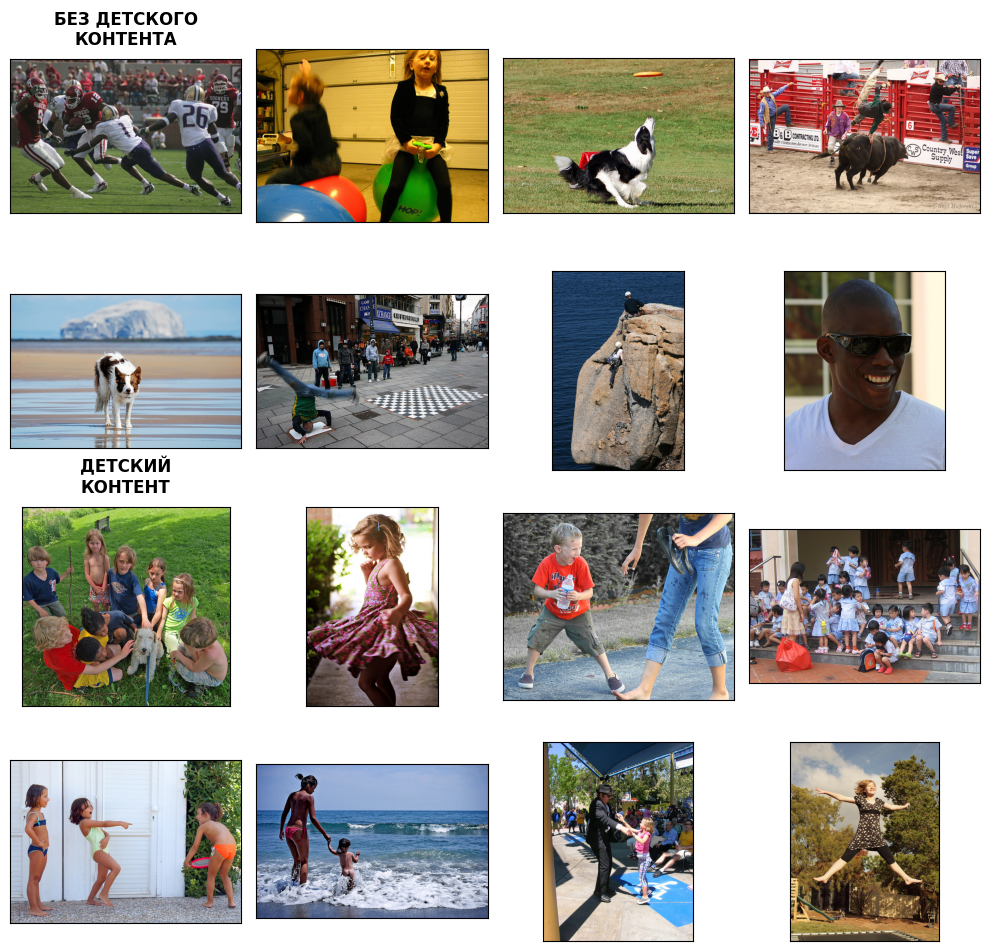

In [30]:
print("=" * 60)
print("СРАВНЕНИЕ ПОСЛЕ ФИЛЬТРАЦИИ")
print("=" * 60)
samples_train = list(train_data['image'].sample(8))
samples_test = random.sample(bad_content, min(8, len(bad_content)))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image_path = os.path.join(DATA_PATH, 'train_images', samples_train[i])
    image = Image.open(image_path)
    
    
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    if i == 0:
        plt.title("БЕЗ ДЕТСКОГО\nКОНТЕНТА", fontsize=12, fontweight='bold', pad=10)
    
    plt.tight_layout()

for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image_path = os.path.join(DATA_PATH, 'train_images', samples_test[i])
    image = Image.open(image_path)
    
    
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    if i == 0:
        plt.title("ДЕТСКИЙ\nКОНТЕНТ", fontsize=12, fontweight='bold', pad=10)
    
    plt.tight_layout()
plt.tight_layout()
plt.subplots_adjust(top=0.92)  
del image

## Векторизация текстов


### Векторизация с помощью трансформеров

In [43]:
model_name = 'all-MiniLM-L6-v2'
text_model = SentenceTransformer(model_name)

In [44]:
def preprocess_text_for_bert(text):
    """
    Упрощенная предобработка текста для BERT-моделей
    """
    # Базовая очистка
    text = str(text).lower().strip()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Убираем спецсимволы, оставляем буквы и пробелы
    text = re.sub(r'\s+', ' ', text)  # Заменяем множественные пробелы на одинарные
    return text.strip()

# Применяем предобработку
train_texts_clean = train_data['query_text'].apply(preprocess_text_for_bert)
test_texts_clean = df_test_queries['query_text'].apply(preprocess_text_for_bert)

print("Примеры обработанных текстов:")
for i, text in enumerate(train_texts_clean.sample(3)):
    print(f"{i+1}. {text}")

Примеры обработанных текстов:
1. a man in an ampitheater talking to a boy
2. a small child climbs a large rock while someone casting a shadow takes her picture
3. a sled and dogs mushing


In [45]:
def get_text_embeddings(texts, model, batch_size=32, show_progress=True):
    """
    Получает эмбеддинги для списка текстов
    """
    embeddings = model.encode(
        texts.tolist(),
        batch_size=batch_size,
        show_progress_bar=show_progress,
        convert_to_numpy=True
    )
    return embeddings

# Векторизуем тренировочные тексты
print("Векторизация тренировочных текстов...")
train_embeddings = get_text_embeddings(train_texts_clean, text_model)

print("Векторизация тестовых текстов...")
test_embeddings = get_text_embeddings(test_texts_clean, text_model)

print(f"Размерность train эмбеддингов: {train_embeddings.shape}")
print(f"Размерность test эмбеддингов: {test_embeddings.shape}")

Векторизация тренировочных текстов...


Batches:   0%|          | 0/1197 [00:00<?, ?it/s]

Векторизация тестовых текстов...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Размерность train эмбеддингов: (38274, 384)
Размерность test эмбеддингов: (500, 384)


In [46]:
def create_embedding_dataframe(embeddings, original_df, prefix='text_'):
    """
    Создает DataFrame с эмбеддингами
    """
    # Создаем DataFrame с эмбеддингами
    embedding_df = pd.DataFrame(embeddings)
    embedding_df.columns = [f'{prefix}{i}' for i in range(embeddings.shape[1])]
    
    # Добавляем идентификаторы
    embedding_df['query_id'] = original_df['query_id'].values
    embedding_df['query_text'] = original_df['query_text'].values
    
    return embedding_df

# Создаем DataFrame для train и test
train_embedding_df = create_embedding_dataframe(train_embeddings, train_data)
test_embedding_df = create_embedding_dataframe(test_embeddings, df_test_queries)

print("Train embeddings DataFrame:")
print(train_embedding_df.shape)
print(train_embedding_df.head())

print("\nTest embeddings DataFrame:")
print(test_embedding_df.shape)
print(test_embedding_df.head())

Train embeddings DataFrame:
(38274, 386)
     text_0    text_1   text_2    text_3    text_4    text_5    text_6  \
0 -0.005041 -0.056275 -0.01701 -0.013267  0.004041  0.050845  0.077975   
1 -0.005041 -0.056275 -0.01701 -0.013267  0.004041  0.050845  0.077975   
2 -0.005041 -0.056275 -0.01701 -0.013267  0.004041  0.050845  0.077975   
3 -0.005041 -0.056275 -0.01701 -0.013267  0.004041  0.050845  0.077975   
4 -0.005041 -0.056275 -0.01701 -0.013267  0.004041  0.050845  0.077975   

     text_7    text_8    text_9  ...  text_376  text_377  text_378  text_379  \
0  0.011977  0.004412 -0.047351  ... -0.001552 -0.033721  -0.07179  0.088162   
1  0.011977  0.004412 -0.047351  ... -0.001552 -0.033721  -0.07179  0.088162   
2  0.011977  0.004412 -0.047351  ... -0.001552 -0.033721  -0.07179  0.088162   
3  0.011977  0.004412 -0.047351  ... -0.001552 -0.033721  -0.07179  0.088162   
4  0.011977  0.004412 -0.047351  ... -0.001552 -0.033721  -0.07179  0.088162   

   text_380  text_381  text_382  

## Векторизация изображений


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
PATH_TRAIN_IMG = 'to_upload/train_images'
PATH_TEST_IMG = 'to_upload/test_images'

In [50]:
def get_resnet_feature_extractor():
    """
    Создает ResNet-18 без полносвязных слоев для извлечения признаков
    """
    # Загружаем предобученную модель
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    
    # Удаляем полносвязные слои (классификатор)
    # Оставляем только сверточные слои и avgpool
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    
    # Переводим модель в режим оценки и на нужное устройство
    feature_extractor.eval()
    feature_extractor.to(device)
    
    return feature_extractor

# Инициализируем модель
feature_extractor = get_resnet_feature_extractor()
print("ResNet-18 feature extractor loaded successfully!")

ResNet-18 feature extractor loaded successfully!


In [51]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [52]:
def extract_image_features(image_path, feature_extractor, transform):
    """
    Извлекает признаки из одного изображения
    """
    try:
        # Загружаем и преобразуем изображение
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)  # Добавляем batch dimension
        
        # Извлекаем признаки
        with torch.no_grad():
            features = feature_extractor(image_tensor)
        
        # Преобразуем в numpy array и выравниваем
        features = features.squeeze().cpu().numpy().flatten()
        return features
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [53]:
def batch_extract_features(image_names, image_folder, feature_extractor, transform, batch_size=32):
    """
    Пакетное извлечение признаков для списка изображений
    """
    features_dict = {}
    
    for i in tqdm(range(0, len(image_names), batch_size)):
        batch_names = image_names[i:i+batch_size]
        batch_features = []
        batch_valid_names = []
        
        for img_name in batch_names:
            img_path = os.path.join(image_folder, img_name)
            if os.path.exists(img_path):
                features = extract_image_features(img_path, feature_extractor, transform)
                if features is not None:
                    batch_features.append(features)
                    batch_valid_names.append(img_name)
        
        if batch_features:
            # Сохраняем признаки
            for name, feat in zip(batch_valid_names, batch_features):
                features_dict[name] = feat
    
    return features_dict

In [54]:
feature_extractor = get_resnet_feature_extractor()
print("ResNet feature extractor loaded successfully!")

ResNet feature extractor loaded successfully!


In [55]:
train_images = train_data['image'].unique().tolist()
print(f"Number of unique train images: {len(train_images)}")

Number of unique train images: 759


In [56]:
print("Extracting features for train images...")
train_features = batch_extract_features(train_images, PATH_TRAIN_IMG, feature_extractor, transform)

Extracting features for train images...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:53<00:00,  2.21s/it]


In [57]:
test_images = df_test_images['image'].unique().tolist()
print(f"Number of unique test images: {len(test_images)}")

Number of unique test images: 100


In [58]:
print("Extracting features for test images...")
test_features = batch_extract_features(test_images, PATH_TEST_IMG, feature_extractor, transform)


Extracting features for test images...


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]


In [59]:
def create_features_dataframe(features_dict, prefix='img_'):
    """
    Создает DataFrame из словаря с признаками
    """
    features_df = pd.DataFrame.from_dict(features_dict, orient='index')
    features_df.columns = [f'{prefix}{i}' for i in range(features_df.shape[1])]
    features_df.index.name = 'image'
    return features_df.reset_index()

# Создаем DataFrame с признаками
train_img_features_df = create_features_dataframe(train_features)
test_img_features_df = create_features_dataframe(test_features)

print(f"Train image features shape: {train_img_features_df.shape}")
print(f"Test image features shape: {test_img_features_df.shape}")

Train image features shape: (759, 513)
Test image features shape: (100, 513)


In [60]:
train_img_features_df.head()

image     img_0     img_1     img_2     img_3  \
0  1056338697_4f7d7ce270.jpg  0.693940  3.031836  2.916933  0.951898   
1  2182488373_df73c7cc09.jpg  0.069861  4.210073  0.766444  0.768750   
2  2843695880_eeea6c67db.jpg  0.562534  0.063393  0.105745  0.510708   
3  2892995070_39f3c9a56e.jpg  0.322125  0.411020  0.828815  0.093954   
4  2934359101_cdf57442dc.jpg  1.802946  0.872300  1.109333  1.942769   

      img_4     img_5     img_6     img_7     img_8  ...   img_502   img_503  \
0  0.936295  1.245117  0.826524  1.107943  0.169679  ...  0.444168  0.717752   
1  0.043305  1.496377  0.143424  1.236888  1.412681  ...  0.698297  0.521458   
2  0.445332  0.576123  0.400998  6.549695  0.627500  ...  0.301728  0.158535   
3  0.861549  0.653505  0.258631  1.256013  0.607121  ...  0.022913  0.000515   
4  0.762159  0.095578  0.486798  0.172363  0.247124  ...  0.110709  1.429842   

    img_504   img_505   img_506   img_507   img_508   img_509   img_510  \
0  0.294673  0.728979  1.153704  0.750852  1.196701  0.085007  1.056700   
1  1.344828  0.931384  0.774726  1.739725  1.955894  1.730252  1.526793   
2  0.649136  0.266551  0.972121  0.387753  0.057231  1.445166  6.567440   
3  1.786023  0.573027  2.108548  0.113510  1.361677  0.457754  4.736521   
4  0.880418  1.286852  1.070734  1.283265  1.430003  1.451513  1.393626   

    img_511  
0  0.098157  
1  1.246415  
2  0.910533  
3  0.322022  
4  0.996206  

[5 rows x 513 columns]

ПОдготовлены данные с векторами изображений для тренировочных и тестовых данных

## Объединение векторов

In [62]:
text_embeddings_df = train_embedding_df.reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

In [63]:
print(f"Размер train_data: {train_data.shape}")
print(f"Размер train_embedding_df: {train_embedding_df.shape}") 
print(f"Размер train_img_features_df: {train_img_features_df.shape}")

Размер train_data: (38274, 4)
Размер train_embedding_df: (38274, 386)
Размер train_img_features_df: (759, 513)


In [64]:
combined_df = pd.concat([
        train_data[['image', 'query_id', 'final_score']],  
        train_embedding_df.drop(['query_id', 'query_text'], axis=1, errors='ignore')
    ], axis=1)

In [65]:
combined_df.isna().sum().sum()

np.int64(0)

In [66]:
final_data = combined_df.merge(train_img_features_df, on='image', how='left')

In [67]:
final_data.isna().sum().sum()

np.int64(0)

##  Обучение модели предсказания соответствия

В качестве метрики выберем RMSE так как эта метрика лучше реагирует на выбросы предсказаниях.

In [68]:
df = final_data.copy()

# Выделяем фичи и таргет
feature_columns = [col for col in df.columns if col.startswith('text_') or col.startswith('img_')]
X = df[feature_columns]
y = df['final_score']

# Группы - это имена изображений, чтобы одно изображение не попало и в train и в test
groups = df['image']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Unique groups (images): {len(groups.unique())}")

X shape: (38274, 896)
y shape: (38274,)
Unique groups (images): 759


In [69]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=groups))

In [70]:
X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")
print(f"Unique images in train: {len(df.iloc[train_indices]['image'].unique())}")
print(f"Unique images in test: {len(df.iloc[test_indices]['image'].unique())}")

# Проверяем, что нет пересечений изображений между train и test
train_images = set(df.iloc[train_indices]['image'].unique())
test_images = set(df.iloc[test_indices]['image'].unique())
print(f"Overlap between train and test images: {len(train_images.intersection(test_images))}")

Train size: 26944
Test size: 11330
Unique images in train: 531
Unique images in test: 228
Overlap between train and test images: 0


In [71]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [72]:
print("RMSE Dummy:", mean_squared_error(y_test, dummy_model.predict(X_test))**0.5)

RMSE Dummy: 0.23377729936922745


In [73]:
l1 = linear_model.Lasso(alpha=0.1)
l1.fit(X_train, y_train)

Lasso(alpha=0.1)

In [74]:
print("RMSE Lasso Regression:", mean_squared_error(y_test, l1.predict(X_test))**0.5)

RMSE Lasso Regression: 0.2174072816202004


### Нейронная сеть

In [78]:
features_train = torch.FloatTensor(np.array(X_train))
features_valid = torch.FloatTensor(np.array(X_test))
target_train = torch.FloatTensor(np.array(y_train))
target_valid = torch.FloatTensor(np.array(y_test))

In [79]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,
                 n_hidden_neurons_4, n_hidden_neurons_5, n_out_neurons):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
            self.act3 = nn.ReLU()
            self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
            self.act4 = nn.ReLU()
            self.fc5 = nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5)
            self.act5 = nn.ReLU()
            self.fc6 = nn.Linear(n_hidden_neurons_5, n_out_neurons)
            self.act6 = nn.Sigmoid()

            nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc5.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc6.weight, mode='fan_in', nonlinearity='sigmoid')

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        x = self.act6(x)

        return x

In [80]:
n_in_neurons = features_train.shape[1]
n_hidden_neurons_1 = 512
n_hidden_neurons_2 = 256
n_hidden_neurons_3 = 128
n_hidden_neurons_4 = 64
n_hidden_neurons_5 = 32
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,
          n_hidden_neurons_4, n_hidden_neurons_5, n_out_neurons)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


loss = nn.MSELoss()

In [81]:
num_epochs = 15
batch_size = 32
num_batches = ceil(len(features_train)/batch_size)

best_rmse = float('inf')  # Инициализация лучшей RMSE
all_rmse = []  

for epoch in range(num_epochs):
    net.train()
    order = np.random.permutation(len(features_train))
    
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        end_index = min(start_index + batch_size, len(features_train))  # Защита от выхода за границы
        
        optimizer.zero_grad()
        batch_indexes = order[start_index:end_index]
        X_batch = features_train[batch_indexes]
        y_batch = target_train[batch_indexes]
        
        preds = net.forward(X_batch.float()).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    # Проверка RMSE на валидационном наборе
    with torch.no_grad():
        net.eval()
        valid_preds = net.forward(features_valid).flatten()
        current_rmse = round(float(torch.sqrt(loss(valid_preds, target_valid))), 3)  

        # Если текущая модель лучше предыдущей лучшей модели, сохраняем ее
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            torch.save(net.state_dict(), 'best_model.pth')

        # Сохраняем RMSE для истории
        all_rmse.append(current_rmse)  

        # Выводим результаты
        if epoch % 1 == 0:
            print(f'Epoch {epoch}: RMSE = {current_rmse}')

print()
print(f'Лучшая RMSE = {best_rmse}')  
print(f'На эпохе: {all_rmse.index(best_rmse)}')
print(f'Все RMSE: {all_rmse}')

Epoch 0: RMSE = 0.209
Epoch 1: RMSE = 0.205
Epoch 2: RMSE = 0.203
Epoch 3: RMSE = 0.2
Epoch 4: RMSE = 0.202
Epoch 5: RMSE = 0.204
Epoch 6: RMSE = 0.207
Epoch 7: RMSE = 0.208
Epoch 8: RMSE = 0.209
Epoch 9: RMSE = 0.213
Epoch 10: RMSE = 0.211
Epoch 11: RMSE = 0.214
Epoch 12: RMSE = 0.209
Epoch 13: RMSE = 0.212
Epoch 14: RMSE = 0.214

Лучшая RMSE = 0.2
На эпохе: 3
Все RMSE: [0.209, 0.205, 0.203, 0.2, 0.202, 0.204, 0.207, 0.208, 0.209, 0.213, 0.211, 0.214, 0.209, 0.212, 0.214]


Лучшая модель оказалась Нейронная сеть с метрикой 0.197   

С ней и будем работать

##  Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [83]:
# проверка детского контента
def check_single_text(text):
        if contains_child_content(text):
            return 1
        else:
            return 0

подготовим вектора картинов в np-массив

In [84]:
test_img_emb = test_img_features_df.drop('image',axis=1)

In [85]:
test_img_emb_np = test_img_emb.values
print(f"Numpy array shape: {test_img_emb_np.shape}")
print(f"Type: {test_img_emb_np.dtype}")

Numpy array shape: (100, 512)
Type: float32


In [86]:
def show(img, title=None):
    """Отображает изображение с заголовком"""
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    if title:
        plt.title(title, fontsize=12, pad=10)
    plt.tight_layout()
    plt.show()

In [87]:
def prepare_txt_test(test_sample):
    
    """векторизация текста и обработка запрещенного контента"""
    for text in test_sample:
        text = preprocess_text_for_bert(text)
        print('Оригинальный текст:', text)
        if check_single_text(text) == 1:
            print(f'''
            {'='*100}
            This image is unavailable in your country in compliance with local laws.
            {'='*100}
            ''')                
        else:
            txt_lemma_embeddings = text_model.encode(text,convert_to_numpy=True)

            
            """Объединение с векторами изображений"""
            X = np.concatenate((
                    np.tile(txt_lemma_embeddings, (test_img_emb.shape[0], 1)),  # Дублируем текстовый вектор
                    test_img_emb  # Вектора изображений
                ), axis=1)
            #print('размер датасета:', X.shape)
            
            """предсказания модели"""
            X = scaler.transform(X)
            X = torch.FloatTensor(X)
            
            net.load_state_dict(torch.load('best_model.pth'))
            result = net.forward(X).flatten().detach().numpy()
            
            
            top5_idx = np.argsort(result)[-5:][::-1]

            # Отображаем 5 изображений
            fig, axes = plt.subplots(1, 5, figsize=(20, 8))
            for i, idx in enumerate(top5_idx):
                img_path = os.path.join(PATH_TEST_IMG, test_img_features_df.iloc[idx]['image'])
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].set_title(f"#{i+1}: {result[idx]:.4f}",fontsize=14)
                axes[i].axis('off')
            plt.show()


**Испытание тествой модели**

Оригинальный текст: a little white dog runs on freshly mown grass holding a small stick


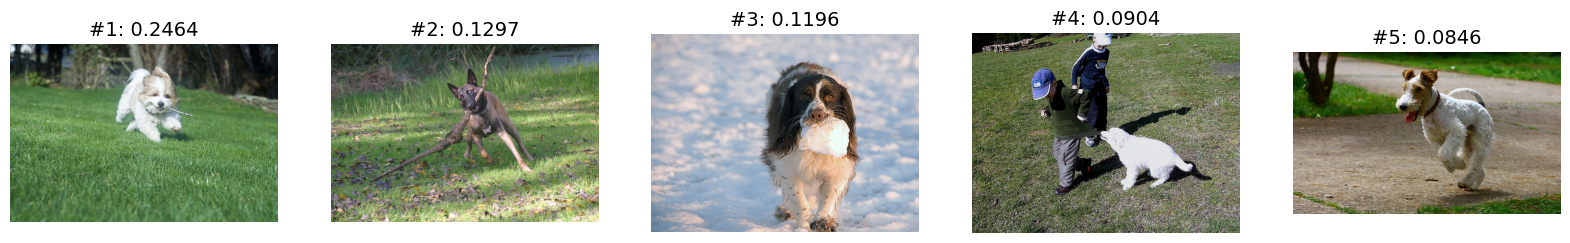

Оригинальный текст: a group of three females and one male dressed in costume


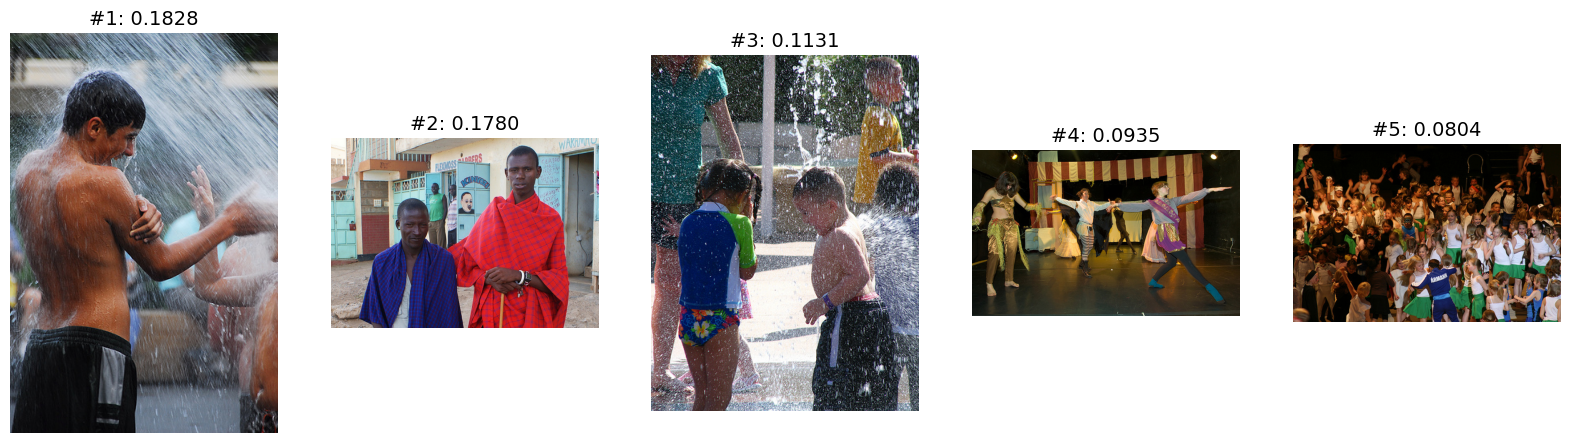

Оригинальный текст: a watercraft speeds through the water


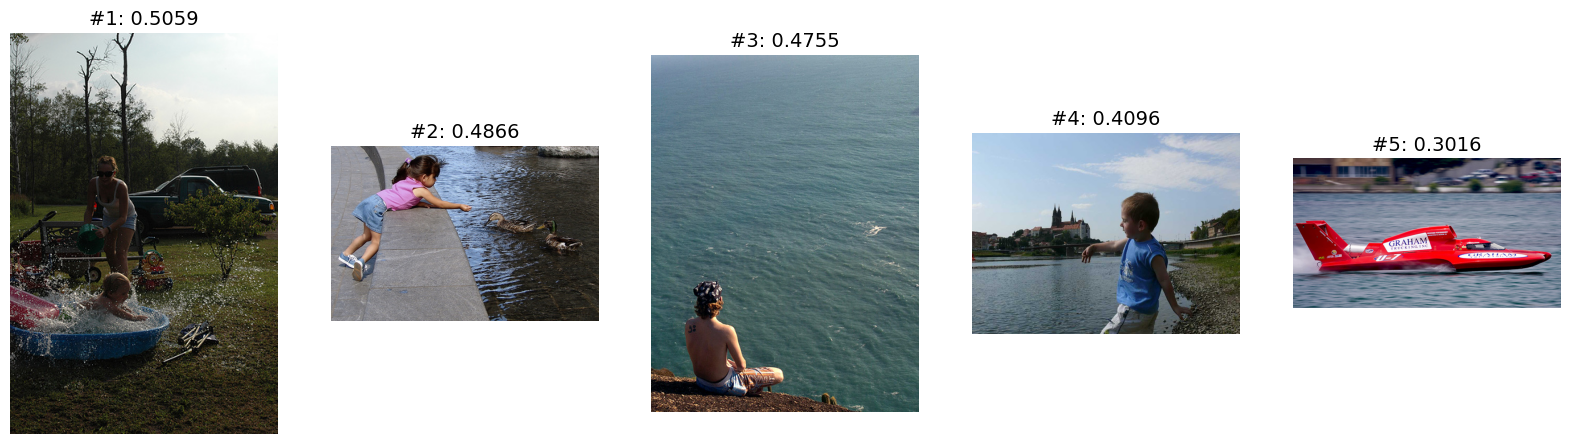

Оригинальный текст: a group of people in a large yard toss a disc


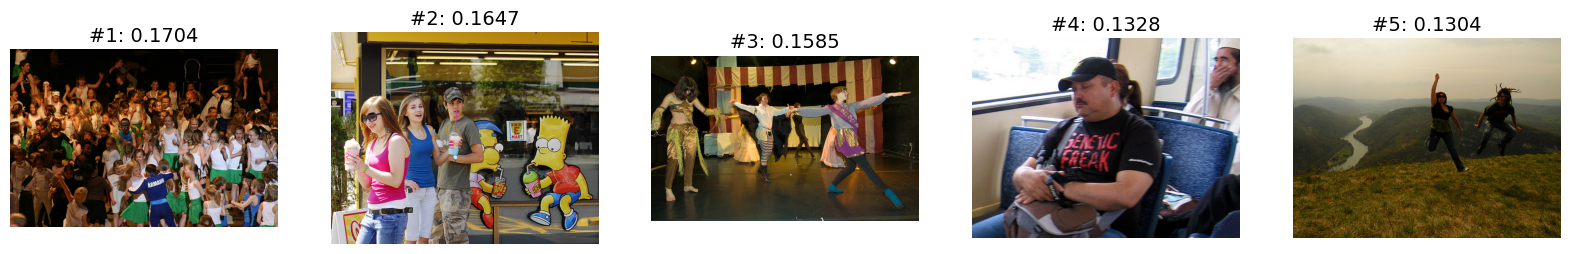

Оригинальный текст: a boy in a blue top is jumping off some rocks in the woods

            This image is unavailable in your country in compliance with local laws.
            
Оригинальный текст: a red haired girl making a peace sign is wearing neon green glasses and floaties and playing in the pool with other kids

            This image is unavailable in your country in compliance with local laws.
            
Оригинальный текст: a little girl wearing a purple winter coat and sunglasses skiing in the snow

            This image is unavailable in your country in compliance with local laws.
            
Оригинальный текст: a white dog and a black dog in a field


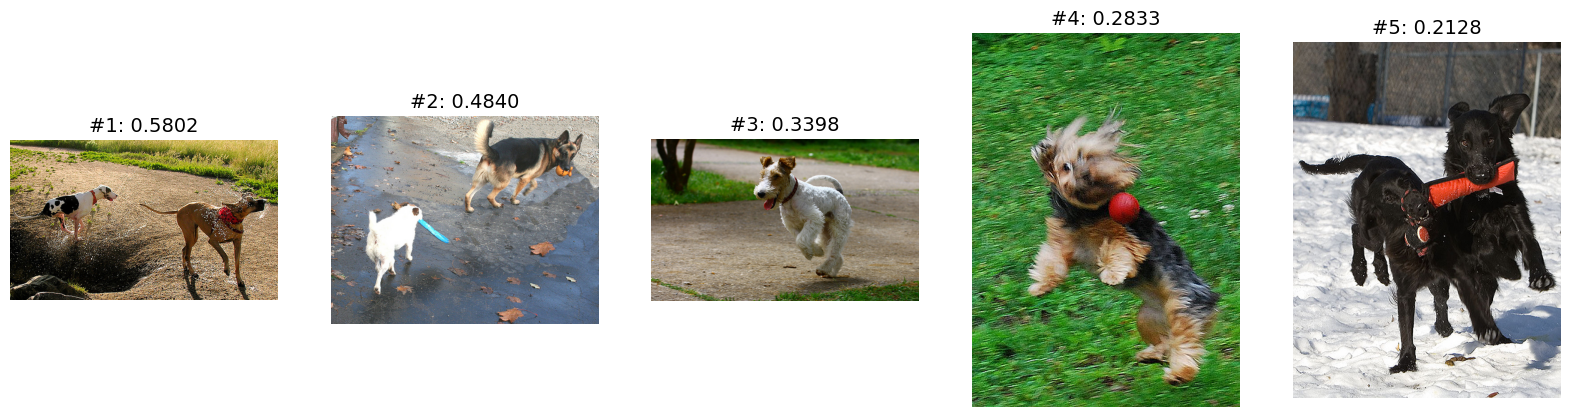

Оригинальный текст: a white dog runs on brown grass


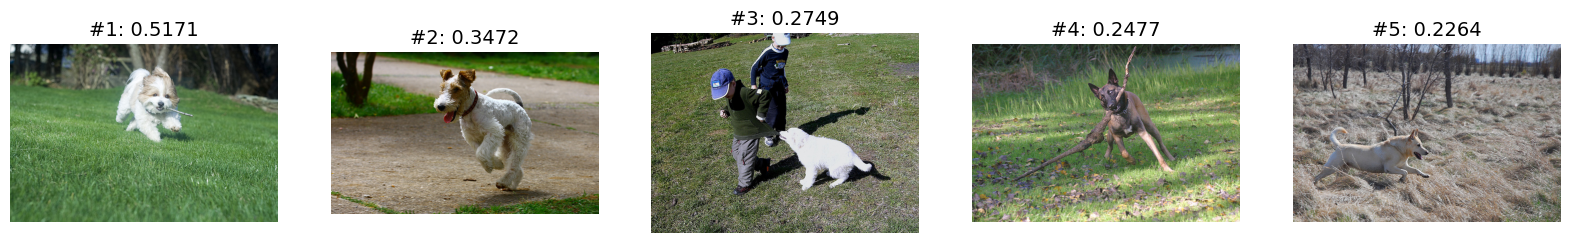

Оригинальный текст: a guy and a girl jumping up in the air

            This image is unavailable in your country in compliance with local laws.
            


In [100]:
test_sample = df_test_queries.sample(10)
text_test = list(test_sample['query_text'])
prepare_txt_test(text_test)

* Точность модели: В большинстве случаев модель демонстрирует адекватное соответствие изображений текстовым запросам.
* Сложные запросы: Для более сложных или специфичных запросов точность ниже, что указывает на необходимость улучшения обработки контекста и действий.
* Юридическая фильтрация: Система успешно блокирует контент с детьми в текстовом запросе, что соответствует требованиям проекта и законодательству.
* Диапазон ошибок: Значения ошибок варьируются от очень низких (~0.005) до довольно высоких (~0.4), что дает понимание о низком качестве.

**ИТОГ**
1. Успешная подготовка данных:

- Проведена агрегация экспертных и краудсорсинговых оценок в единую целевую переменную (0-1)

- Реализована фильтрация контента, связанного с детьми, в соответствии с законодательными требованиями


2. Создание признаков:

- Текстовые признаки: BERT векторизация с лемматизацией и очисткой текста 
- Визуальные признаки: извлечение с помощью предобученной ResNet-18 
- Объединены в единое пространство признаков для обучения модели

3. Обучение модели:

- Реализовано корректное разделение данных с учетом групп (изображений) через GroupShuffleSplit

- Протестированы различные модели (Dummy, Lasso, neural Net)

- neural Net показал наилучшие результаты на тестовой выборке

4. Проблемы и ограничения
 - Качество предсказаний:
    - Модель демонстрирует приемлимые показатели, в первых картинках есть схожие попадания

5. Вычислительная сложность:

    - Извлечение признаков изображений требует значительных ресурсов

    - Обучение на объединенных признаках высокой размерности computationally expensive


6. Рекомендации по улучшению

- Расширение данных:

    - Увеличение размера обучающей выборки

    - Применение аугментации для изображений и текстов

Проект успешно демонстрирует рабочий pipeline для поиска изображений по текстовым запросам, но требует дальнейшей доработки для достижения production-качества.